# Determining an analytical composite IMF for randomly sampled IMFs

This file serves to show how one can determine the analytical form of a composite IMF, i.e. an IMF that consists of the IMFs of several star clusters, so-called stellar IMFs. 
The following algorithm is able to determine the value of the composite IMF $\xi_{\mathrm{cIMF}}(m)$ for a set of masses.

## Why and when is it useful:

Determining the form of a composite IMF can be useful for the investigation of star-formation in sub-galactic regions. It can be useful, if there is a set of cluster masses known, and one wants to determine the composite IMF of this system without having to generate a large number of randomly sampled IMFs in order to better the statistics. The function presented here can be used to determine the expected form of the composite IMF under the assumption that all IMFs are randomly sampled.

## How does it work:

The composite IMF similar to the IGIMF is given as a sum of stellar IMFs:

#### $$\xi_{\mathrm{cIMF}}(m)=\sum_{i=1}^{N} k_i\xi_i(m)$$

For each stellar IMF, its form is correlated with the mass of its cluster such that

$M_{\mathrm{ecl,i}} = \int_{m_{\mathrm{min}}}^{m_{\mathrm{max}}(M_{\mathrm{ecl,i}})} k_i\xi_i(m)\times m \, \mathrm{d}m$, where the upper integration bound $m_{\mathrm{max}}(M_{\mathrm{ecl,i}})$ depends on the cluster mass $M_{\mathrm{ecl,i}}$. This can be used to determine the normalization constant of the cluster's IMF, via

#### $$k_i = \frac{M_{\mathrm{ecl,i}}}{\int_{m_{\mathrm{min}}}^{m_{\mathrm{max}}(M_{\mathrm{ecl,i}})} \xi_i(m)\times m \, \mathrm{d}m}$$

with $m_{\mathrm{max}}(M_{\mathrm{ecl}})=\begin{cases} m_{\mathrm{max}}=150.0 M_{\odot}, \quad M_{\mathrm{ecl}}>150.0 M_{\odot},\\ m_{\mathrm{max}}=M_{\mathrm{ecl}}, \quad M_{\mathrm{ecl}}< 150.0 M_{\odot}  \end{cases}$.

In this way, one constructs a composite IMF function dependent on the stellar mass $m$, that takes the masses of the embedded clusters as input.

#### $$\xi_{\mathrm{cIMF}}(m)=\sum_{i=1}^{N} k_i\xi_i(m) = \sum_{i=1}^{N} \frac{M_{\mathrm{ecl,i}}}{\int_{m_{\mathrm{min}}}^{m_{\mathrm{max}}(M_{\mathrm{ecl,i}})} \xi_i(m)\times m \, \mathrm{d}m} \xi_i(m) $$

## The Algorithm

### First, three functions from the galIMF module are taken, with which several IMF forms can be described.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
from scipy.optimize import root_scalar

In [2]:
def function_alpha_1_change(alpha1_model, M_over_H):
    alpha_1 = 1.3
    if (alpha1_model == 0):
        return alpha_1
    elif (alpha1_model == 1):
        alpha_1_change = alpha_1 + 0.5 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'IGIMF2.5'):
        alpha_1_change = alpha_1 + 0.12 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'Z_MW'):
        alpha_1_change = alpha_1 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        return alpha_1_change
    elif (alpha1_model == 'Z'):
        alpha_1_change = alpha_1 + 63 * (10**M_over_H - 1) * 0.0142
        return alpha_1_change
    else:
        print('Invalid Input for alpha1 model')
        return

## Function to change alpha_2 depending on the model; imported from galimf.py
def function_alpha_2_change(alpha2_model, M_over_H):
    alpha_2=2.3
    if (alpha2_model == 0):
        return alpha_2
    elif (alpha2_model == 1):
        alpha_2_change = alpha_2 + 0.5 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'Z_MW'):
        alpha_2_change = alpha_2 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'Z'):
        alpha_2_change = alpha_2 + 63 * (10**M_over_H - 1) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'IGIMF2.5'):
        alpha_2_change = alpha_2 + 0.12 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'R14'):
        alpha_2_change = 2.3 + 0.0572 * M_over_H
        return alpha_2_change
    else:
        print('Invalid input for alpha2 model')
        return

def function_alpha_3_change(alpha3_model, M_ecl, M_over_H):
    ## M_ecl is the mass of the cluster
    ## M_over_H is the metallicity of the cluster, but apparently is in reality [Z]
    ## since the formula for model 2 is similar to the formula from Yan et al.(2021)
    ## where [Z] is used, I assume that M_over_H is actually [Z]
    ## alpha3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
    if (alpha3_model == 0):
        default_alpha3 = 2.3
        # print("alpha_3 is set to be a constant: %s, as this is the default alpha_3 value for alpha3_model 0.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (default_alpha3))
        return default_alpha3
    elif (alpha3_model == 1):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        if rho < 9.5 * 10 ** 4:
            alpha_3_change = 2.3
        else:
            alpha_3_change = 1.86 - 0.43 * math.log(rho / 10 ** 6, 10)
        # print("Notification in file 'alpha3_model' uncompleted")
        if alpha_3_change < 0.5:
            print("IMF alpha_3 being", alpha_3_change, "out of the tested range from Marks et al. 2012.")
        return alpha_3_change
    elif (alpha3_model == 2):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        x = -0.14 * M_over_H + 0.99 * math.log(rho / 10 ** 6, 10)
        if x < -0.87:
            alpha_3_change = 2.3
        else:
            alpha_3_change = -0.41 * x + 1.94
        # print("Notification in file 'alpha3_model' uncompleted")
        return alpha_3_change
    elif (alpha3_model == 'R14'):
        alpha_3_change = 2.3 + 0.0572 * M_over_H
        return alpha_3_change
    else:
        # print("alpha_3 is set to be a constant: %s, as this is the input value of parameter 'alpha3_model'.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (alpha3_model))
        return alpha3_model

### Then, a function to determine the value of $m_{\mathrm{max}}$ is defined, considering the stellar IMF is randomly sampled.

Here, it is assumed, that each star cluster has to consist of at least 10 stars. Since each star has a minimal mass of $m_{\mathrm{min}}=0.08\,M_{\odot}$ the maximum stellar mass $m_{\mathrm{max}}$ can only be $150.0\,M_{\odot}$ , if the cluster has a stellar mass of at least $1\times 150.0\,M_{\odot} + 9\times 0.08\,M_{\odot} = 150.72\,M_{\odot}$. This definition could of course be changed as desired.

In [3]:
## define the mmax function

def mmax_func(M_ecl):
    if M_ecl>=150.0+0.72: ## add 9 stars with 0.08 so a cluster consists of at least 10 stars
        return 150.0
    else:
        return M_ecl -0.72 ## mass of most massive stars can be this at mass

## And using those functions, the normalization constant of each IMF can be determined directly from its cluster mass $M_{\mathrm{ecl}}$, while considering the form of the IMF

In [4]:
def normalization_constant_random(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity):

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=mmax_func(M_ecl)

    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)


    def IMF_m(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return x**(1-alpha_1)
        if m_1<=x<m_2:
            return x**(1-alpha_2)*m_1**(alpha_2-alpha_1)
        if m_2<=x<=m_max:
            return x**(1-alpha_3)*m_1**(alpha_2-alpha_1)
        if x>m_max:
            return 0
        
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]
    return normalization_constant

## And finally, the value of cIMF (or IGIMF) at each stellar mass can be determined by adding up the IMFs of each embedded cluster

This function takes in the masses of the clusters and a grid of stellar masses. It determines the values of the IMFs for each stellar mass and returns an array of the values of the composite IMF for the points on the mass grid.

In [5]:
## Define the cIMF/IGIMF function as a sum of IMFs
## This function is the cIMF/IGIMF that comes out, when the stellar IMF is randomly sampled

def IGIMF_random_sampling(M_ecl_array, m_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity):

    ### define the IMF again as a function
    def IMF_func(m, M_ecl):

        ## Parameters given by Theory
        M_turn=0.5
        M_turn2=1.0

        m_0=0.08
        m_1=0.5
        m_2=1.0
        m_max=mmax_func(M_ecl)


        ## Calculation of the IMF exponents
        alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
        alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
        alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

        ## Calculation of the IMF normalization constants k1, k2 and k3
        Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
        Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
        Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

        k_1 = 1/(Term_1+Term_2+Term_3)
        k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

        def IMF(x):
            if x<m_0:
                return 0
            if m_0<=x<m_1:
                return k_1*x**(-alpha_1)
            if m_1<=x<m_2:
                return k_2*x**(-alpha_2)
            if m_2<=x<=m_max:
                return k_3*x**(-alpha_3)
            if x>m_max:
                return 0
        
        return IMF(m)
    
    ## Define the IGIMF as a sum of IMFs
    IGIMF_array=np.array([])
    def IGIMF_func(m, M_ecl_array):
        IGIMF=0
        for i in range(len(M_ecl_array)):
            IGIMF+=normalization_constant_random(M_ecl_array[i], alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)*IMF_func(m, M_ecl_array[i])
        return IGIMF
    
    ## Calculate the IGIMF for each mass in the mass array
    for i in range(len(m_array)):
        IGIMF_array=np.append(IGIMF_array, IGIMF_func(m_array[i], M_ecl_array))
        #print(m_array[i])
    
    return IGIMF_array

In [6]:
import time

In [8]:
## Choose a varying IMF
alpha_1_model='Z'
alpha_2_model='Z'
alpha_3_model=2
Metallicity= 0 ## in [Z]

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array=np.loadtxt('Clusters_in_LMC_Mtot_4e6_beta_2_PL_new.txt')
M_ecl_array=M_ecl_array[:5]

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

t0 = time.time()

#IGIMF_array_random=IGIMF_random_sampling(M_ecl_array, m_input_array)
IGIMF_array_optimal=IGIMF_random_sampling(M_ecl_array, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)

t1 = time.time()

total = t1-t0
print('The total runtime for 1000 points on the mass grid is about',total, 'seconds')

The total runtime for 1000 points on the mass grid is about 4.928999900817871 seconds


## Make new IGIMF func that is faster bc it does not always recalculate the normalization (Its way! faster: 0.04s compared to 4.9s previously!)

In [9]:
def normalization_constant_random(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity):

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=mmax_func(M_ecl)

    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)


    def IMF_m(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return x**(1-alpha_1)
        if m_1<=x<m_2:
            return x**(1-alpha_2)*m_1**(alpha_2-alpha_1)
        if m_2<=x<=m_max:
            return x**(1-alpha_3)*m_1**(alpha_2-alpha_1)
        if x>m_max:
            return 0
        
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]
    return normalization_constant, m_max

In [10]:
## New faster function

## Define the cIMF/IGIMF function as a sum of IMFs
## This function is the cIMF/IGIMF that comes out, when the stellar IMF is randomly sampled

def IGIMF_random_sampling(M_ecl_array, m_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity):

    ### define the IMF again as a function
    def IMF_func(m, M_ecl, k1, M_max):

        ## Parameters given by Theory
        M_turn=0.5
        M_turn2=1.0

        m_0=0.08
        m_1=0.5
        m_2=1.0
        m_max=M_max


        ## Calculation of the IMF exponents
        alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
        alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
        alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

        k_1 = k1
        k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

        def IMF(x):
            if x<m_0:
                return 0
            if m_0<=x<m_1:
                return k_1*x**(-alpha_1)
            if m_1<=x<m_2:
                return k_2*x**(-alpha_2)
            if m_2<=x<=m_max:
                return k_3*x**(-alpha_3)
            if x>m_max:
                return 0
        
        return IMF(m)

    IGIMF_array=np.zeros(len(m_array))
    def IGIMF_func(IGIMF_arr,m_array, M_ecl, k, M_max):
        ## calculate the normalization and m_max once to derive the xi value for each point on the mass grid
        norm=k
        m_max=M_max
        i=0
        while i<len(m_array):
            IGIMF_arr[i]+=IMF_func(m_array[i], M_ecl, norm, m_max)
            i=i+1
            ## if m_array becomes greater than m_max all other new entries will be zero
            if m_array[i]>m_max:
                break
        return IGIMF_arr

    i=0
    while i<len(M_ecl_array):
        k, M_max =normalization_constant_random(M_ecl_array[i], alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)
        IGIMF_array=IGIMF_func(IGIMF_array, m_array, M_ecl_array[i], k, M_max)
        #print('Currently at cluster with M=', M_ecl_array[i])
        i=i+1
    
    ## Define the IGIMF as a sum of IMFs
   # IGIMF_array=np.array([])
   # def IGIMF_func(m, M_ecl_array):
   #     IGIMF=0
   #     for i in range(len(M_ecl_array)):
   #         IGIMF+=normalization_constant_random(M_ecl_array[i], alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)*IMF_func(m, M_ecl_array[i])
   #     return IGIMF
   # 
    ## Calculate the IGIMF for each mass in the mass array
   # for i in range(len(m_array)):
   #     IGIMF_array=np.append(IGIMF_array, IGIMF_func(m_array[i], M_ecl_array))
   #     #print(m_array[i])
   # 
    return IGIMF_array

In [11]:
## Choose a varying IMF
alpha_1_model='Z'
alpha_2_model='Z'
alpha_3_model=2
Metallicity= 0 ## in [Z]

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array=np.loadtxt('Clusters_in_LMC_Mtot_4e6_beta_2_PL_new.txt')
M_ecl_array=M_ecl_array[:5]

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

t0 = time.time()

#IGIMF_array_random=IGIMF_random_sampling(M_ecl_array, m_input_array)
IGIMF_array_optimal=IGIMF_random_sampling(M_ecl_array, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)

t1 = time.time()

total = t1-t0
print('The total runtime for 1000 points on the mass grid is about',total, 'seconds')

The total runtime for 1000 points on the mass grid is about 0.037000179290771484 seconds


## Examples

In [16]:
## Choose a varying IMF
alpha_1_model='Z'
alpha_2_model='Z'
alpha_3_model=2
Metallicity= 0 ## in [Z]

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array=np.loadtxt('Clusters_in_LMC_Mtot_4e6_beta_2_PL_new.txt')
M_ecl_array=M_ecl_array[:5]

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random=IGIMF_random_sampling(M_ecl_array, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)
#IGIMF_array_optimal=IGIMF_optimal_sampling(M_ecl_array, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)

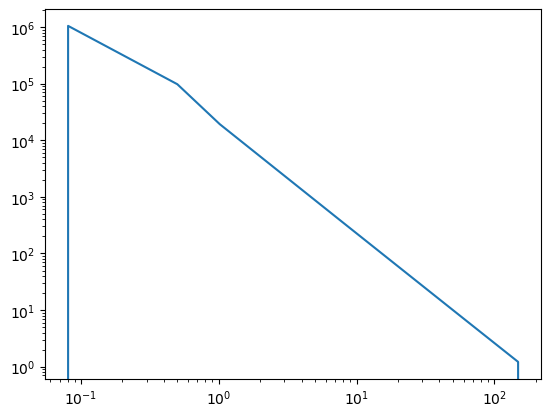

In [17]:
plt.loglog(m_input_array,IGIMF_array_random)

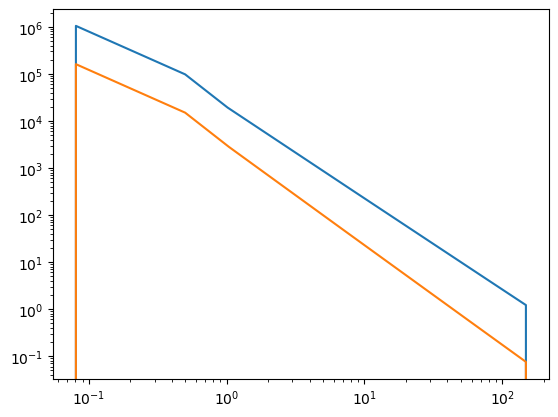

In [19]:
## Choose a varying IMF
alpha_1_model='Z'
alpha_2_model='Z'
alpha_3_model=2
Metallicity= 0 ## in [Z]

M_ecl_array2=np.array([100,200,500,1e4,2e4,4e4])
IGIMF_array_random2=IGIMF_random_sampling(M_ecl_array2, m_input_array, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)
plt.loglog(m_input_array,IGIMF_array_random)
plt.loglog(m_input_array,IGIMF_array_random2)